In [1]:
import random
import pandas as pd
from pymongo import MongoClient
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import matplotlib.cm as cm
import warnings

In [2]:
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Or if you are using > Python 3.11:
with warnings.catch_warnings(action="ignore"):
    fxn()

In [3]:
# Conectar a MongoDB
client = MongoClient("mongodb://localhost:27017/")
database = client["ETIB_TFM"]
collection = database["data_model"]

In [4]:
# Rango de fechas
start_date = datetime(2024, 11, 13)
end_date = datetime(2024, 11, 14)

# Obtener los datos de MongoDB
query = {"Fecha_Transaccion": {"$gte": start_date, "$lt": end_date}}
cursor = collection.find(query)

#Convertir los datos a un DataFrame de Pandas
df_pandas = pd.DataFrame(list(cursor))

# Mostrar las primeras filas del DataFrame
df_pandas.head()

,_id,Dispositivo,Emisor,Estacion_Parada,Fase,Fecha_Clearing,Fecha_Transaccion,Hora_Pico_SN,ID_Vehiculo,Linea,...,Valor,archivo,cenefa,Hora,Año,Mes,Día,Fecha,longitud_paradero,latitud_paradero
0,67472002f909cbe62008b415,220007277,(3101000) Bogota Card(Citizen),(51103) 016A04_TM|016A04_Centro Comercial Port...,Fase 3,2024-11-12,2024-11-13 00:00:02,Peak Time,107142,(1372) T21,...,0.0,Validacion_001_CONSORCIO EXPRESS USAQUEN_20241...,016A04,0,2024,11,13,2024-11-13,-74.111766,4.709791
1,6747203bf909cbe6201e4ba1,220000882,(3101000) Bogota Card(Citizen),(52334) 265A11_TM|265A11_Br. Vista Hermosa,Fase 3,2024-11-12,2024-11-13 00:01:15,Peak Time,207044,(1138) T11,...,0.0,Validacion_002_MASIVO CAPITAL SUBA ORIENTAL_20...,265A11,0,2024,11,13,2024-11-13,-74.149375,4.546931
2,67471e59f909cbe62002f212,220008865,(3200601) Itaú,(57309) 217A00_TM|217A00_Pq. P�blico La Reserva,Fase 3,2024-11-12,2024-11-13 00:02:43,Peak Time,157105,(1064) T13,...,2950.0,Validacion_011_CONSORCIO EXPRESS SAN CRISTOBAL...,217A00,0,2024,11,13,2024-11-13,-74.039616,4.678390
3,67471e5bf909cbe62004020f,220006839,(3101000) Bogota Card(Citizen),(53368) 058A12_TM|058A12_Br. Tenerife,Fase 3,2024-11-12,2024-11-13 00:07:27,Peak Time,937140,(10127) HA708,...,0.0,Validacion_018_GRAN AMERICAS USME_20241112.csv,058A12,0,2024,11,13,2024-11-13,-74.114731,4.505537
4,67472029f909cbe62017a440,220002863,(3101000) Bogota Card(Citizen),(51954) 486A09_TM|486A09_Br. Jos�ar�Carbonell,Fase 3,2024-11-12,2024-11-13 00:08:29,Peak Time,707065,(1025) 94,...,2950.0,Validacion_007_ETIB_20241112.csv,486A09,0,2024,11,13,2024-11-13,-74.197389,4.605388


In [6]:
# Especificamos la ruta que queremos optimizar
ruta = "(8257) 94_20241028_V5"  # Ruta a optimizar
df_route_no_optimized = df_pandas[df_pandas['Ruta']==ruta]
df_route_no_optimized = df_route_no_optimized[df_route_no_optimized['ID_Vehiculo']=='704101']
df_route_no_optimized = df_route_no_optimized.sort_values(by=['Ruta', 'ID_Vehiculo', 'Fecha_Transaccion'])
df_route_no_optimized = df_route_no_optimized.drop_duplicates(subset=['cenefa', 'latitud_paradero', 'longitud_paradero'])

In [10]:
df_route_no_optimized

,_id,Dispositivo,Emisor,Estacion_Parada,Fase,Fecha_Clearing,Fecha_Transaccion,Hora_Pico_SN,ID_Vehiculo,Linea,...,Valor,archivo,cenefa,Hora,Año,Mes,Día,Fecha,longitud_paradero,latitud_paradero
16044,67472089f909cbe6203a25d1,220000422,(3101000) Bogota Card(Citizen),(57962) 126A09_TM|126A09_Br. El Jard,Fase 3,2024-11-13,2024-11-13 06:09:24,Peak Time,704101,(1025) 94,...,2950.0,Validacion_007_ETIB_20241113.csv,126A09,6,2024,11,13,2024-11-13,-74.211174,4.613453
16411,67472089f909cbe6203a297b,220000422,(3200502) Codensa (Sin Franquicia),(58628) 689A09_TM|689A09_Br. Bosa San Jos,Fase 3,2024-11-13,2024-11-13 06:11:14,Peak Time,704101,(1025) 94,...,2950.0,Validacion_007_ETIB_20241113.csv,689A09,6,2024,11,13,2024-11-13,-74.209186,4.612168
16669,67472089f909cbe6203a2c37,220000422,(3101000) Bogota Card(Citizen),(51411) 144A09_TM|144A09_Br. San Diego Bosa,Fase 3,2024-11-13,2024-11-13 06:12:38,Peak Time,704101,(1025) 94,...,2950.0,Validacion_007_ETIB_20241113.csv,144A09,6,2024,11,13,2024-11-13,-74.206717,4.611976
17746,67472089f909cbe6203a34e1,220000422,(3101000) Bogota Card(Citizen),(51407) 136A09_TM|136A09_Br. Manzanares,Fase 3,2024-11-13,2024-11-13 06:17:10,Peak Time,704101,(1025) 94,...,2500.0,Validacion_007_ETIB_20241113.csv,136A09,6,2024,11,13,2024-11-13,-74.201795,4.608665
18217,67472089f909cbe6203a38d5,220000422,(3101000) Bogota Card(Citizen),(51448) 168A09_TM|168A09_Br. Villa Anny I,Fase 3,2024-11-13,2024-11-13 06:19:05,Peak Time,704101,(1025) 94,...,0.0,Validacion_007_ETIB_20241113.csv,168A09,6,2024,11,13,2024-11-13,-74.200109,4.607405
18589,67472089f909cbe6203a3c04,220000422,(3101000) Bogota Card(Citizen),(51446) 166A09_TM|166A09_Br. Carlos Alb�Holgu,Fase 3,2024-11-13,2024-11-13 06:20:45,Peak Time,704101,(1025) 94,...,2950.0,Validacion_007_ETIB_20241113.csv,166A09,6,2024,11,13,2024-11-13,-74.197894,4.605714
20436,67472089f909cbe6203a4b51,220000422,(3101000) Bogota Card(Citizen),(51188) 052D09_TM|052D09_Zona Recreativa La Av...,Fase 3,2024-11-13,2024-11-13 06:28:22,Peak Time,704101,(1025) 94,...,2950.0,Validacion_007_ETIB_20241113.csv,052D09,6,2024,11,13,2024-11-13,-74.184915,4.607627
22785,6747208af909cbe6203a5e92,220000422,(3101000) Bogota Card(Citizen),(50995) 569A09_TM|569A09_CAI Roma,Fase 3,2024-11-13,2024-11-13 06:38:57,Peak Time,704101,(1025) 94,...,2950.0,Validacion_007_ETIB_20241113.csv,569A09,6,2024,11,13,2024-11-13,-74.175308,4.613780
25719,6747208af909cbe6203a7686,220000422,(3101000) Bogota Card(Citizen),(53642) 026B08_TM|026B08_Br. Llano Grande,Fase 3,2024-11-13,2024-11-13 06:52:23,Peak Time,704101,(1025) 94,...,2950.0,Validacion_007_ETIB_20241113.csv,026B08,6,2024,11,13,2024-11-13,-74.166429,4.631433
28473,6747208af909cbe6203a8d8b,220000422,(3101000) Bogota Card(Citizen),(53834) 112B08_TM|112B08_Br. Llano Grande,Fase 3,2024-11-13,2024-11-13 07:06:25,Peak Time,704101,(1025) 94,...,2950.0,Validacion_007_ETIB_20241113.csv,112B08,7,2024,11,13,2024-11-13,-74.163626,4.633872


In [11]:
cenefas = ["126A09",	"689A09",	"144A09",	"148A09",	"136A09",	"168A09",	"166A09",	"634A09",	"177A09",	"070A09",	"659A09",	"071B09",	"073A09",	"052D09",	"520B09",	"054B09",	"100B09",	"305A09",	"569A09",	"172A08",	"174B08",	"176B08",	"167A08",	"163A08",	"035A08",	"599A08",	"034A08",	"032B08",	"024B08",	"026B08",	"112B08",	"112A08",	"028B08",	"160B08",	"356B07",	"123B07",	"124B07",	"040A07",	"126B07",	"364A07",	"343B07",	"130A07",	"067A06",	"026A06",	"429A06",	"028A06",	"430A06",	"029A06",	"028A05",	"009A05",	"010A05",	"011A05",	"029A05",	"013A05",	"006A04",	"007A04",	"008A04",	"009A04",	"011A04",	"007A03",	"048A03",	"593A03",	"082A03",	"079A03",	"050A03",	"203A03",	"008A03",	"103A03",	"205A03",	"078A03",	"586A03",	"190A03",	"105A03",	"013A03",	"424A03",	"433A03",	"097A03",	"098A03",	"100A03",	"101A03",	"469A03",	"616A03",	"681A03",	"468A03",	"102A03",	"099A03",	"012A03",	"011A03",	"579A03",	"010A03",	"204A03",	"104A03",	"009A03",	"202A03",	"051A03",	"080A03",	"081A03",	"049A03",	"006A03",	"010A04",	"112A04",	"111A04",	"110A04",	"005A04",	"050A05",	"012A05",	"034A05",	"453A05",	"169A05",	"030A05",	"168A05",	"153A06",	"193A06",	"027A06",	"191A06",	"154A06",	"155A06",	"128A07",	"342A07",	"129A07",	"349A07",	"127A07",	"125A07",	"122A07",	"052B08",	"003A08",	"115A08",	"114A08",	"006A08",	"008A08",	"179A08",	"165A08",	"177A08",	"175A08",	"173A08",	"610A09",	"101A09",	"102A09",	"511A09",	"051B09",	"074A09",	"230A09",	"226A09",	"072A09",	"069A09",	"178A09",	"167A09",	"486A09",	"490A09",	"137A09",	"149A09",	"145A09",	"676A09",	"127A09"]

In [12]:
df_cenefas = pd.DataFrame(cenefas, columns=['cenefa'])

In [13]:
df_cenefas['Index'] = df_cenefas.index

In [14]:
df_merge = df_route_no_optimized.merge(df_cenefas, on='cenefa')

In [15]:
df_merge = df_merge.sort_values(by='Index')

In [16]:
# Crear los edges a partir de la columna 'cenefa'
# Emparejar cada valor de 'cenefa' con el siguiente para formar los edges
edges = [(df_merge.iloc[i]['cenefa'], df_merge.iloc[i+1]['cenefa']) 
         for i in range(len(df_merge)-1)]

# Lista de puntos geográficos (longitud y latitud)
latitudes = df_merge['latitud_paradero'].tolist()
longitudes = df_merge['longitud_paradero'].tolist()

# Crear un DataFrame con los edges y las coordenadas correspondientes
edges_df = pd.DataFrame(edges, columns=['start', 'end'])
edges_df['start_lat'] = latitudes[:-1]
edges_df['start_long'] = longitudes[:-1]
edges_df['end_lat'] = latitudes[1:]
edges_df['end_long'] = longitudes[1:]

In [17]:
shapefile = gpd.read_file('../maps/Loca.shp')
shapefile
shapefile_filtered = shapefile[~shapefile['LocNombre'].isin(['USME', 'SUMAPAZ','CIUDAD BOLIVAR'])]
shapefile_filtered
shapefile = shapefile_filtered

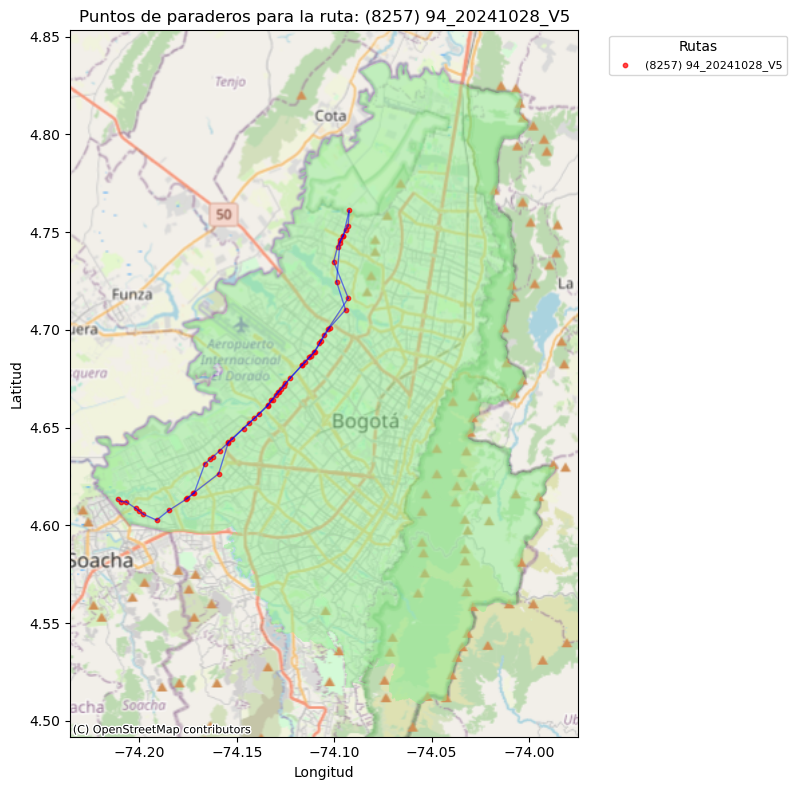

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))

# Dibujar el mapa base de Bogotá
shapefile.plot(ax=ax, color='lightgreen', alpha=0.5)
#colors = cm.get_cmap('tab10', 1)

# Agregar la capa base de OpenStreetMap
ctx.add_basemap(ax, crs=shapefile.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Graficar los puntos de paraderos para la ruta actual
ax.scatter(df_merge['longitud_paradero'], df_merge['latitud_paradero'], 
           label=ruta, color='red', alpha=0.7, s=10)
#ax.plot(df_route_no_optimized['longitud_paradero'], df_route_no_optimized['latitud_paradero'])

# Graficar las líneas de los edges (aristas)
for index, row in edges_df.iterrows():
    ax.plot([row['start_long'], row['end_long']], [row['start_lat'], row['end_lat']], 
            color='blue', alpha=0.5, linewidth=1)

# Añadir título y etiquetas
ax.set_title(f"Puntos de paraderos para la ruta: {ruta}")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

# Ajustar la leyenda para que no ocupe tanto espacio
ax.legend(title="Rutas", loc='upper left', fontsize=8, bbox_to_anchor=(1.05, 1))

# Mostrar el mapa
plt.tight_layout()  # Ajustar el espacio para evitar recorte
# Guardar la imagen como archivo PNG
#output_filename = f"../images/mapa_ruta_{route}.png"
#plt.savefig(output_filename, dpi=300, bbox_inches='tight')

plt.show(fig)
# Cerrar la figura después de guardarla
#plt.close(fig)

In [19]:
def haversine(lat1, lon1, lat2, lon2):
    """Calcula la distancia entre dos puntos geográficos (lat1, lon1) y (lat2, lon2) usando la fórmula de Haversine."""
    R = 6371.0  # Radio de la Tierra en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

In [ ]:
# Inicializamos la variable para la distancia total
distancia_total = 0

for i in range(len(df_merge) - 1):
    parada_actual = df_merge.iloc[i]
    parada_siguiente = df_merge.iloc[i+1]
    
    # Calculamos la distancia entre las paradas consecutivas
    distancia = haversine(parada_actual['latitud_paradero'], parada_actual['longitud_paradero'],
                          parada_siguiente['latitud_paradero'], parada_siguiente['longitud_paradero'])
    
    # Sumamos la distancia a la distancia total
    distancia_total += distancia
# Mostramos la distancia total
print(f"Distancia total recorrida: {distancia_total} 7 km")

# WITH ACO

In [21]:
import networkx as nx
import numpy as np
from math import radians, sin, cos, sqrt, atan2

# Función para calcular la distancia entre dos puntos geográficos (Haversine)
def haversine(lat1, lon1, lat2, lon2):
    # Conversión de grados a radianes
    R = 6371.0  # Radio de la Tierra en kilómetros
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

# Crear un grafo dirigido (porque las rutas tienen direcciones)
G = nx.DiGraph()

# Añadir nodos y aristas al grafo
for i in range(len(df_merge) - 1):
    # Nodo actual y siguiente en la secuencia de transacciones
    nodo_actual = df_merge.iloc[i]['cenefa']
    nodo_siguiente = df_merge.iloc[i + 1]['cenefa']
    
    # Coordenadas de los nodos
    lat1, lon1 = df_merge.iloc[i]['latitud_paradero'], df_merge.iloc[i]['longitud_paradero']
    lat2, lon2 = df_merge.iloc[i + 1]['latitud_paradero'], df_merge.iloc[i + 1]['longitud_paradero']
    
    # Calcular la distancia entre los nodos
    distancia = haversine(lat1, lon1, lat2, lon2)
    
    # Añadir los nodos y la arista al grafo con el peso de la distancia
    G.add_edge(nodo_actual, nodo_siguiente, weight=distancia)

# Verificar el grafo
print(f"Nodos: {G.number_of_nodes()}")
print(f"Aristas: {G.number_of_edges()}")

Nodos: 59
Aristas: 58


In [22]:
print(G.nodes)

['126A09', '689A09', '144A09', '136A09', '168A09', '166A09', '070A09', '052D09', '569A09', '174B08', '026B08', '112B08', '028B08', '160B08', '356B07', '123B07', '040A07', '126B07', '364A07', '130A07', '067A06', '026A06', '429A06', '028A06', '029A06', '028A05', '009A05', '010A05', '011A05', '013A05', '007A04', '011A04', '079A03', '078A03', '586A03', '102A03', '012A03', '011A03', '579A03', '010A03', '204A03', '009A03', '006A03', '110A04', '005A04', '012A05', '453A05', '169A05', '168A05', '193A06', '191A06', '154A06', '155A06', '128A07', '342A07', '122A07', '006A08', '175A08', '610A09']


In [23]:
print(G.edges)

[('126A09', '689A09'), ('689A09', '144A09'), ('144A09', '136A09'), ('136A09', '168A09'), ('168A09', '166A09'), ('166A09', '070A09'), ('070A09', '052D09'), ('052D09', '569A09'), ('569A09', '174B08'), ('174B08', '026B08'), ('026B08', '112B08'), ('112B08', '028B08'), ('028B08', '160B08'), ('160B08', '356B07'), ('356B07', '123B07'), ('123B07', '040A07'), ('040A07', '126B07'), ('126B07', '364A07'), ('364A07', '130A07'), ('130A07', '067A06'), ('067A06', '026A06'), ('026A06', '429A06'), ('429A06', '028A06'), ('028A06', '029A06'), ('029A06', '028A05'), ('028A05', '009A05'), ('009A05', '010A05'), ('010A05', '011A05'), ('011A05', '013A05'), ('013A05', '007A04'), ('007A04', '011A04'), ('011A04', '079A03'), ('079A03', '078A03'), ('078A03', '586A03'), ('586A03', '102A03'), ('102A03', '012A03'), ('012A03', '011A03'), ('011A03', '579A03'), ('579A03', '010A03'), ('010A03', '204A03'), ('204A03', '009A03'), ('009A03', '006A03'), ('006A03', '110A04'), ('110A04', '005A04'), ('005A04', '012A05'), ('012A05'

In [27]:
import numpy as np
import networkx as nx
import random

class ACO:
    def __init__(self, G, num_hormigas, num_iteraciones, alpha=1.0, beta=2.0, rho=0.5, Q=100):
        """
        Inicializa el algoritmo ACO.
        
        Parámetros:
        - G: El grafo que contiene las paradas y distancias.
        - num_hormigas: Número de hormigas que explorarán las rutas.
        - num_iteraciones: Número de iteraciones del algoritmo.
        - alpha: Controla la influencia de la feromona.
        - beta: Controla la influencia de la distancia.
        - rho: Tasa de evaporación de feromonas.
        - Q: Cantidad de feromona depositada por cada hormiga.
        """
        self.G = G
        self.num_hormigas = num_hormigas
        self.num_iteraciones = num_iteraciones
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = Q
        
        # Inicializamos las feromonas en cada arista con un valor pequeño positivo
        self.feromonas = {edge: 1.0 for edge in self.G.edges}
    
    def distancia(self, nodo1, nodo2):
        """ Devuelve la distancia entre dos nodos """
        return self.G[nodo1][nodo2]['weight']
    
    def probabilidad(self, nodo_actual, nodo_siguiente, disponibles):
        """ Calcula la probabilidad de elegir la próxima parada basado en la feromona y la distancia """
        feromona_actual = self.feromonas[(nodo_actual, nodo_siguiente)] ** self.alpha
        distancia_actual = (1.0 / self.distancia(nodo_actual, nodo_siguiente)) ** self.beta
        
        # Sumamos todas las probabilidades de las opciones disponibles
        suma_total = sum(
            (self.feromonas[(nodo_actual, destino)] ** self.alpha) * 
            ((1.0 / self.distancia(nodo_actual, destino)) ** self.beta) 
            for destino in disponibles
        )
        
        return (feromona_actual * distancia_actual) / suma_total
    
    def evaporar_feromonas(self):
        """ Aplica la evaporación de feromonas en todas las aristas """
        for edge in self.feromonas:
            self.feromonas[edge] *= (1.0 - self.rho)
    
    def depositar_feromonas(self, caminos):
        """ Deposita feromonas en las rutas recorridas por las hormigas """
        for camino, distancia in caminos:
            for i in range(len(camino) - 1):
                self.feromonas[(camino[i], camino[i+1])] += self.Q / distancia
    
    def generar_camino(self, inicio, fin):
        """ Genera un camino de inicio a fin basado en las probabilidades ACO """
        camino = [inicio]
        nodos_disponibles = set(self.G.nodes()) - {inicio}
        nodo_actual = inicio
        distancia_total = 0.0
        
        while nodo_actual != fin:
            # Verifica los nodos disponibles conectados al nodo actual
            vecinos = [nodo for nodo in nodos_disponibles if (nodo_actual, nodo) in self.G.edges() or (nodo, nodo_actual) in self.G.edges()]
            
            if not vecinos:
                raise ValueError(f"No hay nodos disponibles conectados a {nodo_actual}")
            
            # Calcula las probabilidades solo para los vecinos disponibles
            probabilidades = [self.probabilidad(nodo_actual, destino, vecinos) for destino in vecinos]
            destino_siguiente = random.choices(vecinos, weights=probabilidades)[0]
            
            # Añade el siguiente destino al camino
            camino.append(destino_siguiente)
            distancia_total += self.distancia(nodo_actual, destino_siguiente)
            nodo_actual = destino_siguiente
            nodos_disponibles.remove(destino_siguiente)
        
        return camino, distancia_total
    
    def optimizar(self, inicio, fin):
        """ Ejecuta el algoritmo ACO para encontrar la ruta óptima """
        mejor_camino = None
        mejor_distancia = float('inf')
        
        for _ in range(self.num_iteraciones):
            caminos = []
            
            for _ in range(self.num_hormigas):
                # Generamos el camino para cada hormiga
                camino, distancia_total = self.generar_camino(inicio, fin)
                caminos.append((camino, distancia_total))
                
                # Verificamos si es el mejor camino hasta ahora
                if distancia_total < mejor_distancia:
                    mejor_camino = camino
                    mejor_distancia = distancia_total
            
            # Evaporamos feromonas y depositamos las nuevas basadas en los caminos recorridos
            self.evaporar_feromonas()
            self.depositar_feromonas(caminos)
        
        return mejor_camino, mejor_distancia

# Ejemplo de uso con un grafo existente:
optimizer = ACO(G, num_hormigas=10, num_iteraciones=100)
start_parada = '126A09'
end_parada = '610A09'
ruta_optima, distancia_optima = optimizer.optimizar(start_parada, end_parada)

print(f"Ruta óptima: {ruta_optima}")
print(f"Distancia óptima: {distancia_optima:.2f} km")

Ruta óptima: ['126A09', '689A09', '144A09', '136A09', '168A09', '166A09', '070A09', '052D09', '569A09', '174B08', '026B08', '112B08', '028B08', '160B08', '356B07', '123B07', '040A07', '126B07', '364A07', '130A07', '067A06', '026A06', '429A06', '028A06', '029A06', '028A05', '009A05', '010A05', '011A05', '013A05', '007A04', '011A04', '079A03', '078A03', '586A03', '102A03', '012A03', '011A03', '579A03', '010A03', '204A03', '009A03', '006A03', '110A04', '005A04', '012A05', '453A05', '169A05', '168A05', '193A06', '191A06', '154A06', '155A06', '128A07', '342A07', '122A07', '006A08', '175A08', '610A09']
Distancia óptima: 44.96 km
